In [ ]:
import os
import shutil
from google.colab import drive

mount_point = '/content/drive'

# Ensure the mount point exists
if not os.path.exists(mount_point):
    os.makedirs(mount_point)

# Clear the mount point if it's not empty
# It's important to only clear if it's a directory and contains files
# to avoid issues if it's already mounted by colab or is a symlink.
if os.path.isdir(mount_point) and os.listdir(mount_point):
    print(f"Clearing non-empty mount point: {mount_point}")
    # Use a loop to remove contents rather than rmtree on the mount point itself
    # as rmtree might fail if the mount is partially active or contains read-only files.
    for item in os.listdir(mount_point):
        item_path = os.path.join(mount_point, item)
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

drive.mount(mount_point)

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Dissertion/Data/Features"
!ls /content


audio  text  vision
drive  sample_data


In [ ]:
import os
import json

OUTPUT_DIR = "/content/drive/MyDrive/Dissertion/Data/labels"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Directory '{OUTPUT_DIR}' created successfully.")
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "data_labels.json")

#Extract RAVDESS Labels

| Emotion Code | Label |
| ------------ | ----- |
| Neutral      | 1     |
| Calm         | 2     |
| Happy        | 3     |
| Sad          | 4     |
| Angry        | 5     |
| Fearful      | 6     |
| Disgust      | 7     |
| Surprised    | 8     |


In [ ]:
def extract_and_append_ravdess_labels(ravdess_root, output_json):
    """
    Extract emotion labels from RAVDESS filenames and append them
    into an existing JSON label file.

    Parameters
    ----------
    ravdess_root : str
        Root folder containing RAVDESS audio files (recursive search).

    output_json : str
        Path to existing JSON label file (will be updated/appended).

    Returns
    -------
    dict
        Updated filename → label dictionary.
    """

    # =========================
    # STEP 1: LOAD EXISTING JSON FILE
    # =========================

    if os.path.exists(output_json):
        with open(output_json, "r") as f:
            filename_emotion = json.load(f)
        print("✅ Existing JSON loaded successfully.")
    else:
        filename_emotion = {}
        print("⚠️ No existing JSON found. Creating a new one.")

    initial_count = len(filename_emotion)

    # =========================
    # STEP 2: TRAVERSE ALL SUBDIRECTORIES RECURSIVELY
    # =========================

    added = 0
    duplicates = 0

    for root, _, files in os.walk(ravdess_root):
        for file in files:

            # Process only WAV files
            if file.endswith(".wav") or file.endswith(".mp4"):

                # Extract emotion code (01–08)
                emotion_code = int(file.split("-")[2])

                # Convert to training label (0–7)
                emotion_label = emotion_code - 1

                # Key without extension
                key = os.path.splitext(file)[0]

                # Append only new entries
                if key not in filename_emotion:
                    filename_emotion[key] = emotion_label
                    added += 1
                else:
                    duplicates += 1

    # =========================
    # STEP 3: SAVE UPDATED JSON FILE
    # =========================

    with open(output_json, "w") as f:
        json.dump(filename_emotion, f, indent=4)

    final_count = len(filename_emotion)

    # =========================
    # STEP 4: PRINT SUMMARY
    # =========================

    print("\n========== ✅ SUMMARY ==========")
    print("Initial JSON entries :", initial_count)
    print("New entries added    :", added)
    print("Duplicates skipped   :", duplicates)
    print("Total JSON entries   :", final_count)
    print("✅ Updated JSON saved to:", output_json)
    print("================================\n")


In [ ]:
RAVDESS_VIDEO_ROOT = "/content/drive/MyDrive/Dissertion/Data/RAVDESS"
extract_and_append_ravdess_labels(RAVDESS_VIDEO_ROOT, OUTPUT_FILE)


✅ Existing JSON loaded successfully.

========== ✅ SUMMARY ==========
Initial JSON entries : 0
New entries added    : 616
Duplicates skipped   : 0
Total JSON entries   : 616
✅ Updated JSON saved to: /content/drive/MyDrive/Dissertion/Data/labels/data_labels.json



In [ ]:
import os

print("Root folder exists:", os.path.exists(RAVDESS_VIDEO_ROOT))
print("Listing root folder:")

print(os.listdir(RAVDESS_VIDEO_ROOT)[:10])

Root folder exists: True
Listing root folder:
['Actor_07', 'Actor_05', 'Actor_03', 'Actor_04', 'Actor_02', 'Actor_06', 'Actor_01']


In [ ]:
RAVDESS_AUDIO_ROOT = "/content/drive/MyDrive/Dissertion/Data/Only_audio"
extract_and_append_ravdess_labels(RAVDESS_AUDIO_ROOT, OUTPUT_FILE)


✅ Existing JSON loaded successfully.

========== ✅ SUMMARY ==========
Initial JSON entries : 616
New entries added    : 2408
Duplicates skipped   : 0
Total JSON entries   : 3024
✅ Updated JSON saved to: /content/drive/MyDrive/Dissertion/Data/labels/data_labels.json



#Extract MELD labels

| Unified Code | Emotion Name | Present in RAVDESS | Present in MELD |
| ------------ | ------------ | ------------------ | --------------- |
| 01           | Neutral      | ✅                  | ✅               |
| 02           | Calm         | ✅                  | ❌               |
| 03           | Happy        | ✅                  | ✅ (Joy)         |
| 04           | Sad          | ✅                  | ✅               |
| 05           | Angry        | ✅                  | ✅               |
| 06           | Fearful      | ✅                  | ✅ (Fear)        |
| 07           | Disgust      | ✅                  | ✅               |
| 08           | Surprised    | ✅                  | ✅               |


In [ ]:
import os
import json
import pandas as pd

# =========================
# CONFIGURATION
# =========================

LABEL_DIR   = "/content/drive/MyDrive/Dissertion/Data/MELD Metadata"
VIDEO_ROOT  = "/content/drive/MyDrive/Dissertion/Data/MELD"         # .mp4 directory
JSON_PATH   = "/content/drive/MyDrive/Dissertion/Data/labels/data_labels.json"        # EXISTING JSON
FILE_EXT    = "mp4"

# =========================
# MELD → RAVDESS MAPPING
# =========================

MELD_TO_RAVDESS = {
    "neutral": 0,
    "joy": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
    "disgust": 6,
    "surprise": 1
}

In [ ]:


# =========================
# STEP 1: LOAD EXISTING JSON
# =========================

with open(JSON_PATH, "r") as f:
    label_dict = json.load(f)

print("Existing labels in JSON:", len(label_dict))

# =========================
# STEP 2: MERGE MELD CSVs
# =========================

dfs = []
for file in os.listdir(LABEL_DIR):
    if file.endswith(".csv"):
        print(f"Loading: {file}")
        dfs.append(pd.read_csv(os.path.join(LABEL_DIR, file)))

merged_df = pd.concat(dfs, ignore_index=True)
merged_df["Emotion"] = merged_df["Emotion"].str.lower().str.strip()

# =========================
# STEP 3: APPEND MELD ENTRIES
# =========================

added = 0
skipped_missing = 0
skipped_existing = 0

for _, row in merged_df.iterrows():
    emotion = row["Emotion"]
    if emotion not in MELD_TO_RAVDESS:
        continue

    dialogue_id  = int(row["Dialogue_ID"])
    utterance_id = int(row["Utterance_ID"])

    file_key  = f"dia{dialogue_id}_utt{utterance_id}"
    file_path = os.path.join(VIDEO_ROOT, file_key + ".mp4")

    # skip missing video
    if not os.path.exists(file_path):
       # print(f"Missing video: {file_path}")
        skipped_missing += 1
        continue

    # skip if already exists
    if file_key in label_dict:
        skipped_existing += 1
        continue

    label_dict[file_key] = MELD_TO_RAVDESS[emotion]
    added += 1




Existing labels in JSON: 3024
Loading: MELD_MET.csv


In [ ]:
# =========================
# STEP 4: SAVE JSON
# =========================

with open(JSON_PATH, "w") as f:
    json.dump(label_dict, f, indent=2)

print("\n===== SUMMARY =====")
print("New entries added     :", added)
print("Skipped (missing mp4) :", skipped_missing)
print("Skipped (already exist):", skipped_existing)
print("Total labels in JSON  :", len(label_dict))


===== SUMMARY =====
New entries added     : 7741
Skipped (missing mp4) : 2248
Skipped (already exist): 0
Total labels in JSON  : 10765


In [ ]:
from collections import Counter

# Get the emotion labels from the dictionary values
emotion_labels = list(label_dict.values())

# Count the occurrences of each label
label_counts = Counter(emotion_labels)

print("\n===== Emotion Label Distribution =====")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count} occurrences")
print("=====================================")


===== Emotion Label Distribution =====
Label 0: 3968 occurrences
Label 1: 1488 occurrences
Label 2: 1788 occurrences
Label 3: 962 occurrences
Label 4: 1305 occurrences
Label 5: 683 occurrences
Label 6: 379 occurrences
Label 7: 192 occurrences


In [ ]:
import json

with open(OUTPUT_FILE,"r") as f:
    filename_emotion = json.load(f)


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


#Class Distribution

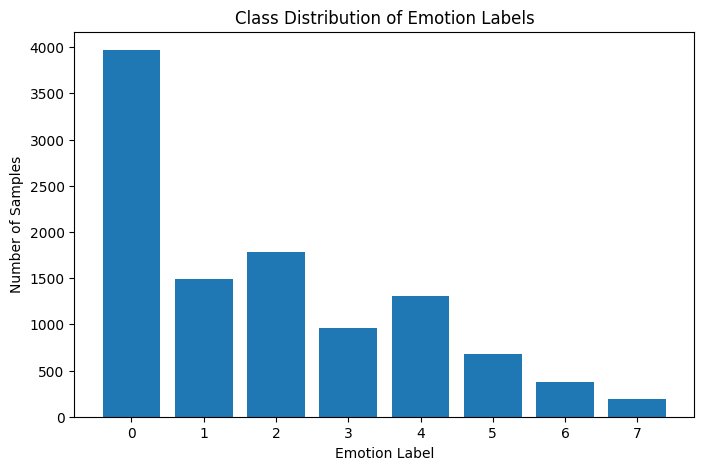

In [ ]:
counts = Counter(filename_emotion.values())

labels = sorted(counts.keys())
values = [counts[l] for l in labels]

plt.figure(figsize=(8,5))
plt.bar(labels, values)
plt.xlabel("Emotion Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of Emotion Labels")
plt.show()


# % class distribution

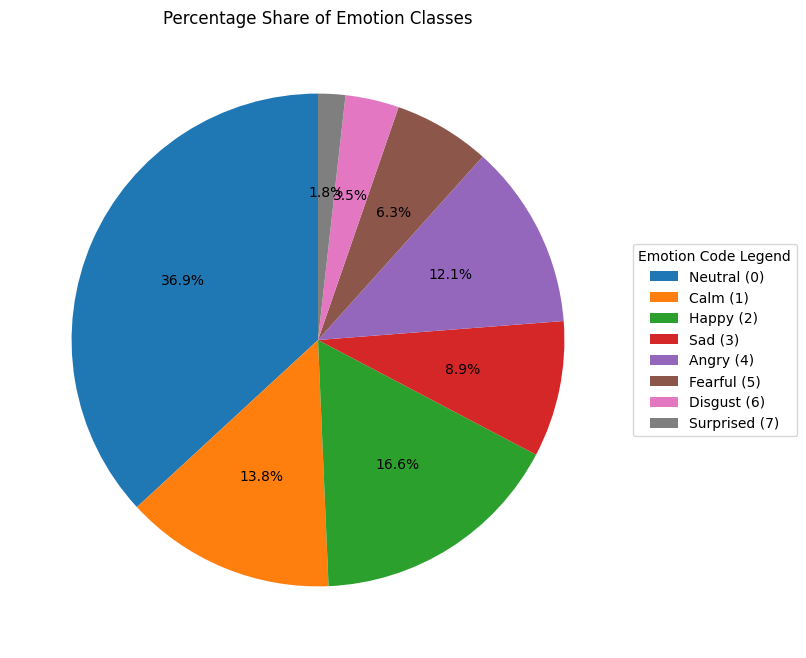

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# -----------------------------
# Emotion Code Mapping
# -----------------------------
emotion_names = {
    0: "Neutral",
    1: "Calm",
    2: "Happy",
    3: "Sad",
    4: "Angry",
    5: "Fearful",
    6: "Disgust",
    7: "Surprised"
}

# -----------------------------
# Count samples per class
# -----------------------------
counts = Counter(filename_emotion.values())

labels = sorted(counts.keys())
values = [counts[l] for l in labels]

# Create legend labels like: Neutral (0)
legend_labels = [f"{emotion_names[l]} ({l})" for l in labels]

# -----------------------------
# Plot Pie Chart
# -----------------------------
plt.figure(figsize=(8, 8))

plt.pie(
    values,
    autopct="%.1f%%",
    startangle=90
)

plt.title("Percentage Share of Emotion Classes")

# Add Legend
plt.legend(
    legend_labels,
    title="Emotion Code Legend",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.show()



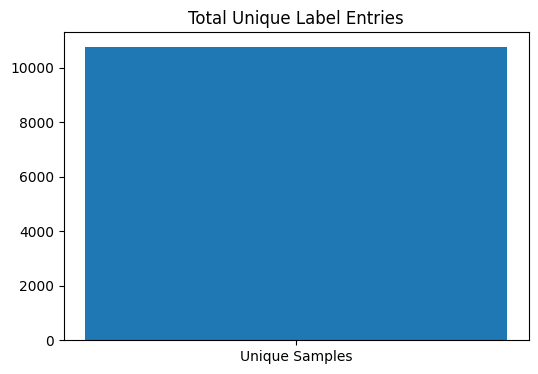

In [ ]:
unique_keys = len(filename_emotion)

plt.figure(figsize=(6,4))
plt.bar(["Unique Samples"], [unique_keys])
plt.title("Total Unique Label Entries")
plt.show()


#Label Entropy (Dataset Diversity)


Entropy measures how evenly your emotion labels are distributed:

Label Entropy: 1.7757901710570039
Max Possible Entropy: 2.0794415416798357


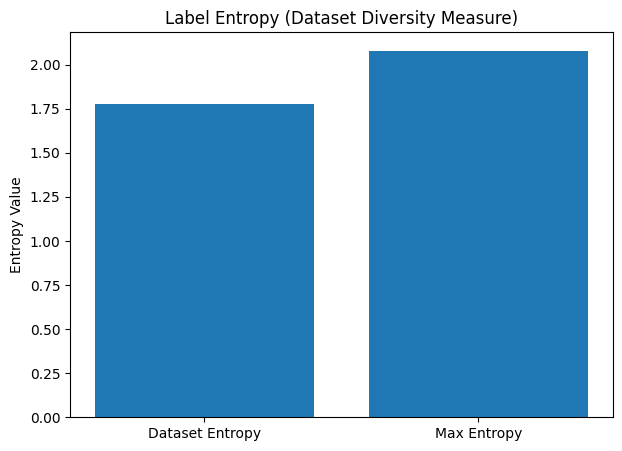

In [ ]:
import math
# -----------------------------
# Count samples per class
# -----------------------------
counts = Counter(filename_emotion.values())

labels = sorted(counts.keys())
values = np.array([counts[l] for l in labels])

total = values.sum()

# -----------------------------
# Compute probabilities
# -----------------------------
p = values / total

# -----------------------------
# Compute Entropy
# -----------------------------
entropy = -sum(pi * math.log(pi) for pi in p if pi > 0)

# Maximum entropy (perfect balance)
num_classes = len(labels)
max_entropy = math.log(num_classes)

print("Label Entropy:", entropy)
print("Max Possible Entropy:", max_entropy)

# -----------------------------
# Plot Entropy vs Max Entropy
# -----------------------------
plt.figure(figsize=(7,5))

plt.bar(
    ["Dataset Entropy", "Max Entropy"],
    [entropy, max_entropy]
)

plt.ylabel("Entropy Value")
plt.title("Label Entropy (Dataset Diversity Measure)")
plt.show()


The label entropy of the dataset was computed to quantify emotion class diversity. The observed entropy value of 1.776 is close to the theoretical maximum of 2.079 for eight classes, corresponding to approximately 85% normalized entropy. This indicates a relatively balanced emotion distribution with moderate class imbalance, supporting robust supervised emotion classification

# Entropy + Gini + Imbalance Index

In [ ]:
def compute_balance_metrics(filename_emotion):
    # Count samples per class
    counts = Counter(filename_emotion.values())

    labels = sorted(counts.keys())
    values = np.array([counts[l] for l in labels])

    total = values.sum()

    # Class probabilities
    p = values / total

    # ---------- Entropy ----------
    entropy = -sum(pi * math.log(pi) for pi in p if pi > 0)
    max_entropy = math.log(len(labels))
    norm_entropy = entropy / max_entropy

    # ---------- Gini Index ----------
    gini = 1 - np.sum(p ** 2)
    gini_max = 1 - 1/len(labels)
    norm_gini = gini / gini_max

    # ---------- Imbalance Index ----------
    imbalance_index = 1 - norm_gini

    return {
        "Entropy": entropy,
        "Max Entropy": max_entropy,
        "Normalized Entropy": norm_entropy,
        "Gini": gini,
        "Max Gini": gini_max,
        "Normalized Gini": norm_gini,
        "Imbalance Index": imbalance_index
    }

# Run metrics
metrics = compute_balance_metrics(filename_emotion)

# Print results
print("\n===== DATASET BALANCE METRICS =====")
for k, v in metrics.items():
    print(f"{k:20s}: {v:.4f}")



===== DATASET BALANCE METRICS =====
Entropy             : 1.7758
Max Entropy         : 2.0794
Normalized Entropy  : 0.8540
Gini                : 0.7892
Max Gini            : 0.8750
Normalized Gini     : 0.9019
Imbalance Index     : 0.0981


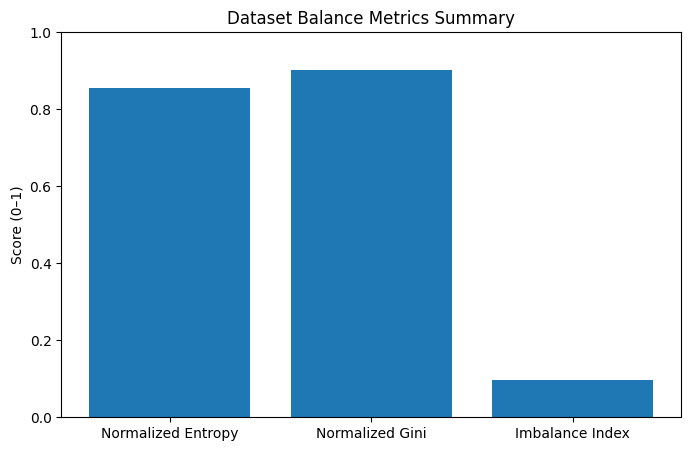

In [ ]:
plt.figure(figsize=(8,5))

plt.bar(
    ["Normalized Entropy", "Normalized Gini", "Imbalance Index"],
    [
        metrics["Normalized Entropy"],
        metrics["Normalized Gini"],
        metrics["Imbalance Index"]
    ]
)

plt.ylim(0, 1)
plt.ylabel("Score (0–1)")
plt.title("Dataset Balance Metrics Summary")
plt.show()


*   Class imbalance was quantified using entropy- and Gini-based diversity measures.

*   The normalized entropy (0.854) indicates high label diversity relative to the theoretical maximum for eight emotion classes.

*   The normalized Gini index (0.902) reflects a near-uniform distribution across emotion categories.

*   The resulting imbalance index (0.098) suggests that the dataset exhibits low class skew.





